In [1]:
import sqlite3
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import f
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# Connect to SQLite database
conn = sqlite3.connect("../data/tidy_finance_python.sqlite")
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('factors_ff3_monthly',), ('factors_ff5_monthly',), ('factors_ff3_daily',), ('industries_ff_monthly10',), ('industries_ff_monthly49',), ('crsp_monthly',), ('beta_monthly',)]


In [3]:
# Load data
factors_ff3_monthly = pd.read_sql("SELECT * FROM factors_ff3_monthly", conn)
industries10 = pd.read_sql("SELECT * FROM industries_ff_monthly10", conn)

In [4]:
# Compute excess returns
industries10_ex = industries10.merge(factors_ff3_monthly[['date', 'rf']], on='date')
for col in industries10.columns[1:]:
    industries10_ex[col + '_ex'] = industries10_ex[col] - industries10_ex['rf']
industries10_ex = industries10_ex[['date'] + [col + '_ex' for col in industries10.columns[1:]]]

In [5]:
# Merge factor data
selected_factors = factors_ff3_monthly.iloc[:, :4]
datdf = selected_factors.merge(industries10_ex, on='date')
industrynames = industries10_ex.columns[1:]

In [6]:
# Initialize storage
N = len(industrynames)
alpha_capm, alpha_ff3 = np.zeros(N), np.zeros(N)
R2adj_capm, R2adj_ff3 = np.zeros(N), np.zeros(N)
tstat_capm, tstat_ff3 = np.zeros(N), np.zeros(N)

In [7]:
# Run regressions
for i, industry in enumerate(industrynames):
    y = datdf[industry]
    X_capm = sm.add_constant(datdf['mkt_excess'])
    X_ff3 = sm.add_constant(datdf[['mkt_excess', 'smb', 'hml']])
    
    model_capm = sm.OLS(y, X_capm).fit()
    model_ff3 = sm.OLS(y, X_ff3).fit()
    
    alpha_capm[i], alpha_ff3[i] = model_capm.params[0], model_ff3.params[0]
    tstat_capm[i], tstat_ff3[i] = model_capm.tvalues[0], model_ff3.tvalues[0]
    R2adj_capm[i], R2adj_ff3[i] = model_capm.rsquared_adj, model_ff3.rsquared_adj
    
    print(i, industry)

sumdf = pd.DataFrame({
    'alpha_capm': alpha_capm, 'alpha_ff3': alpha_ff3,
    'tstat_capm': tstat_capm, 'tstat_ff3': tstat_ff3,
    'R2adj_capm': R2adj_capm, 'R2adj_ff3': R2adj_ff3
})

0 nodur_ex
1 durbl_ex
2 manuf_ex
3 enrgy_ex
4 hitec_ex
5 telcm_ex
6 shops_ex
7 hlth _ex
8 utils_ex
9 other_ex


/var/folders/gw/zkt1hnc96ws27g_xrt1hp51w0000gn/T/ipykernel_83359/71761266.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_capm[i], alpha_ff3[i] = model_capm.params[0], model_ff3.params[0]
/var/folders/gw/zkt1hnc96ws27g_xrt1hp51w0000gn/T/ipykernel_83359/71761266.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tstat_capm[i], tstat_ff3[i] = model_capm.tvalues[0], model_ff3.tvalues[0]
/var/folders/gw/zkt1hnc96ws27g_xrt1hp51w0000gn/T/ipykernel_83359/71761266.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels 

In [8]:
# GRS Test
factor_data = factors_ff3_monthly[['date', 'mkt_excess', 'smb', 'hml']]
portfolio_data = industries10_ex.drop(columns=['date'])
data_merged = industries10_ex.merge(factor_data, on='date')

reg_results = [sm.OLS(data_merged[portfolio], sm.add_constant(data_merged[['mkt_excess', 'smb', 'hml']])).fit() for portfolio in portfolio_data.columns]
alphas = np.array([model.params[0] for model in reg_results])
residuals = np.column_stack([model.resid for model in reg_results])

Sigma = np.cov(residuals, rowvar=False)
factor_means = factor_data.drop(columns=['date']).mean().values
Sigma_f = np.cov(factor_data.drop(columns=['date']), rowvar=False)

T, N, K = len(data_merged), len(alphas), factor_data.shape[1] - 1
inv_Sigma = np.linalg.inv(Sigma)
inv_Sigma_f = np.linalg.inv(Sigma_f)

GRS_numerator = alphas.T @ inv_Sigma @ alphas
GRS_denominator = 1 + factor_means.T @ inv_Sigma_f @ factor_means
GRS_stat = (T - N - K) / N * (GRS_numerator / GRS_denominator)
GRS_p_value = 1 - f.cdf(GRS_stat, N, T - N - K)
GRS_critical = f.ppf(1 - 0.05, N, T - N - K)

GRS_results = pd.DataFrame({
    'GRS_Statistic': [GRS_stat],
    'GRS_Critical': [GRS_critical],
    'p_value': [GRS_p_value]
})
print(GRS_results)

   GRS_Statistic  GRS_Critical   p_value
0       3.360615      1.843032  0.000266


/var/folders/gw/zkt1hnc96ws27g_xrt1hp51w0000gn/T/ipykernel_83359/2748139231.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alphas = np.array([model.params[0] for model in reg_results])


In [9]:
# PCA
industry_pca_data = industries10_ex.drop(columns=['date'])
pca = PCA()
pca_result = pca.fit_transform((industry_pca_data - industry_pca_data.mean()) / industry_pca_data.std())

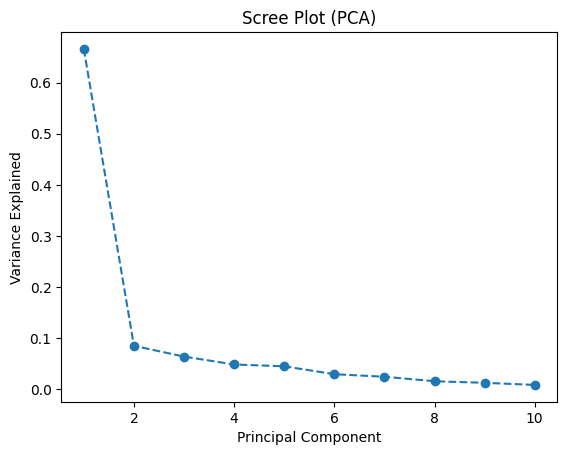

In [10]:
# Scree Plot
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot (PCA)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

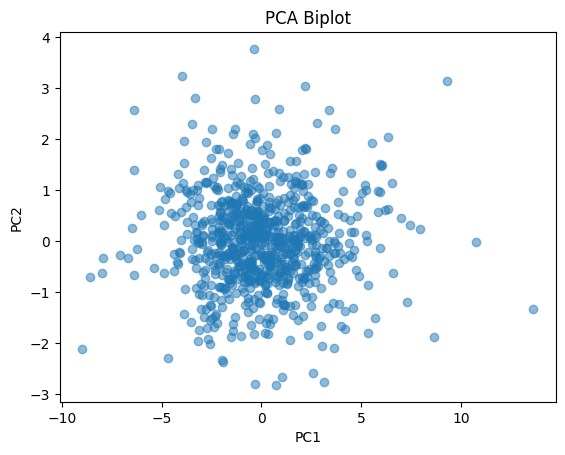

In [11]:
# Biplot (First Two Components)
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Biplot')
plt.show()

In [12]:
# Extract Principal Components and Scores
pca_loadings = pca.components_.T
y_pca = industry_pca_data @ pca_loadings[:, :3]  # Using first 3 PCs
y_pca_df = pd.concat([factors_ff3_monthly[['date']], pd.DataFrame(y_pca.to_numpy(), columns=['PC1', 'PC2', 'PC3'])], axis=1)

print(y_pca_df.head())

                  date       PC1       PC2       PC3
0  1960-01-01 00:00:00  0.193423 -0.040578 -0.066240
1  1960-02-01 00:00:00 -0.051579  0.016959 -0.054149
2  1960-03-01 00:00:00  0.036779 -0.014981 -0.034267
3  1960-04-01 00:00:00  0.026790  0.006284 -0.052407
4  1960-05-01 00:00:00 -0.114676  0.050458 -0.105411
